In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

sns.set()

In [2]:
df = pd.read_csv('data/fixed_raw_data.csv')

# 1 Data Visualization

## 1.1 Price distribution

In [3]:
n_bins = int(np.log10(df.shape[0]) * 3.2 + 1) # n_bins=12

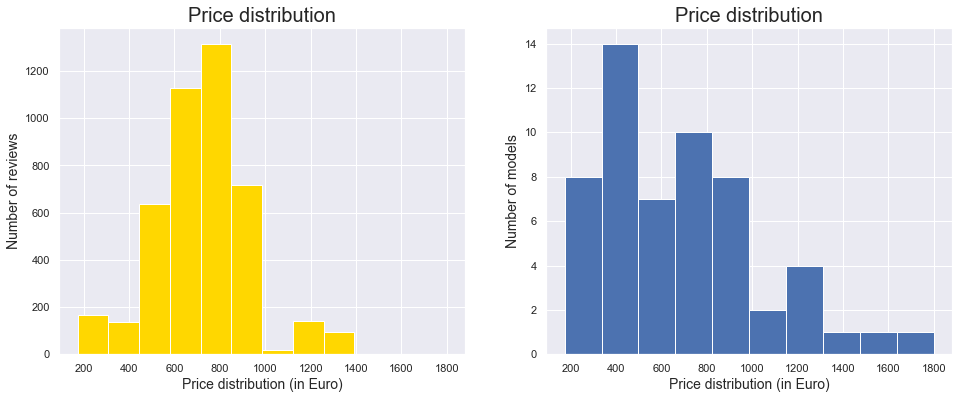

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

df['Price'].hist(color='gold', bins=n_bins, ax=axes[0])
axes[0].set_xlabel('Price distribution (in Euro)', fontsize=14)
axes[0].set_ylabel('Number of reviews', fontsize=14)
axes[0].set_title('Price distribution', fontsize=20)

df.groupby(['Brand', 'Model'])['Price'].mean().hist(bins=10, ax=axes[1])
axes[1].set_xlabel('Price distribution (in Euro)', fontsize=14)
axes[1].set_ylabel('Number of models', fontsize=14)
axes[1].set_title('Price distribution', fontsize=20)

plt.savefig('imgs/Price_dist.png');

Let's look at 'outliers'

In [5]:
df[df['Price']>1400].groupby('Model')["Price"].agg(['mean', 'count'])

,mean,count
Model,,
Galaxy Z Flip 5G,1509,1
Galaxy Z Fold 2 5G,1799,1


Let's look on similar figures for every brand.

In [6]:
color_dic = {'huawei': 'indianred', 'apple': 'silver', 'samsung':'dodgerblue', 
             'google': 'orangered', 'oneplus': 'red', 
             'xiaomi': 'darkorange', 'oppo': 'seagreen', 'nokia': 'royalblue', 
             'vivo': 'cornflowerblue'}

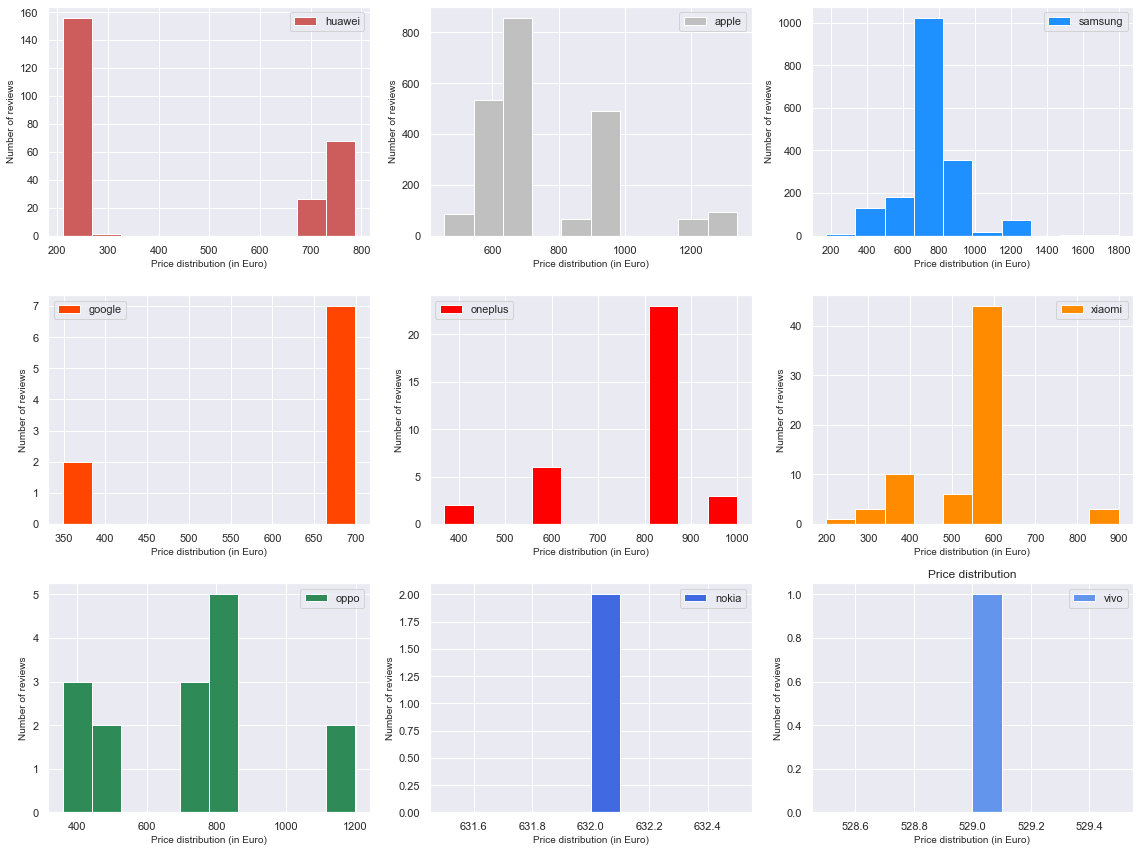

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

list_of_brands = df.Brand.unique()

for n, i in enumerate(list_of_brands):
    r, c = n//3, n%3
    brand_price = df[df['Brand'] == i]['Price']
    cax = brand_price.hist(ax=axes[r, c], color=color_dic[i], label=i)
    cax.set_xlabel('Price distribution (in Euro)', fontsize=10)
    cax.set_ylabel('Number of reviews', fontsize=10);
    cax.legend()

fig.tight_layout()

plt.savefig('imgs/Price_dist_brand.png');

## 1.2 Review Distribution over Brands

In the previous section it can be noticed that there are several brands with the very insignificant numbers of reviews. It should be explored more attentively.

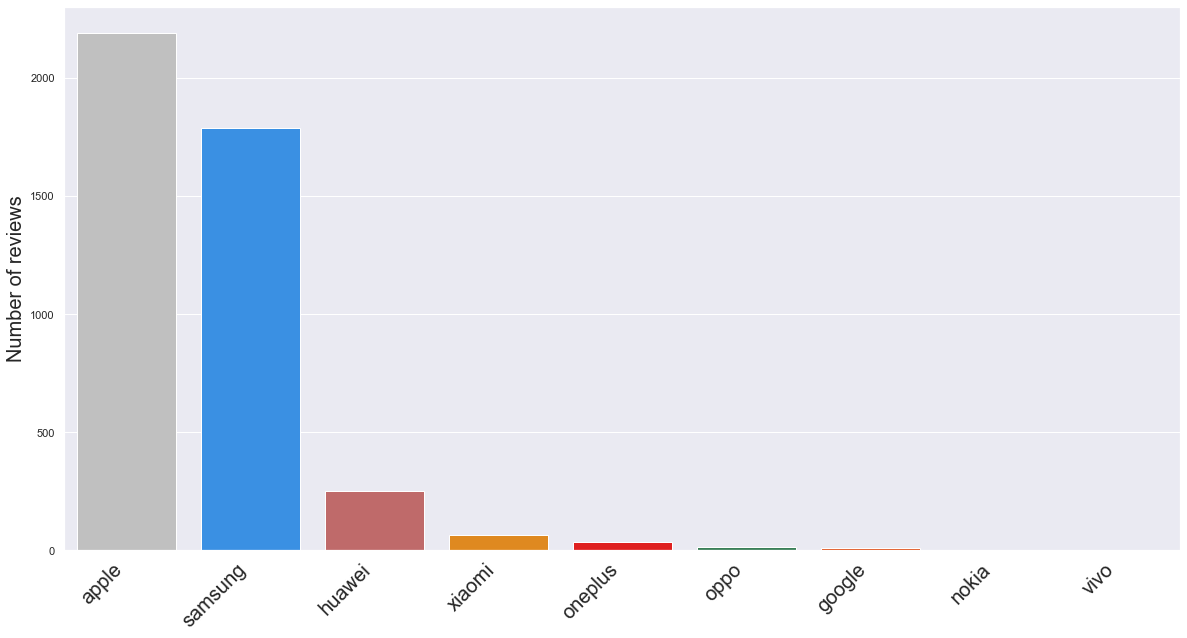

In [8]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=df['Brand'].value_counts().index, y=df['Brand'].value_counts().values, palette=color_dic)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontdict={'fontsize': 20})
ax.set_ylabel('Number of reviews', fontsize=20);
plt.savefig('imgs/review_dist.png')

### We can see that it makes sense to work with apple and samsung more thoroughly in the next paragraph. However, we keep visualize all brands in this one.

## 1.3 Rate distribution

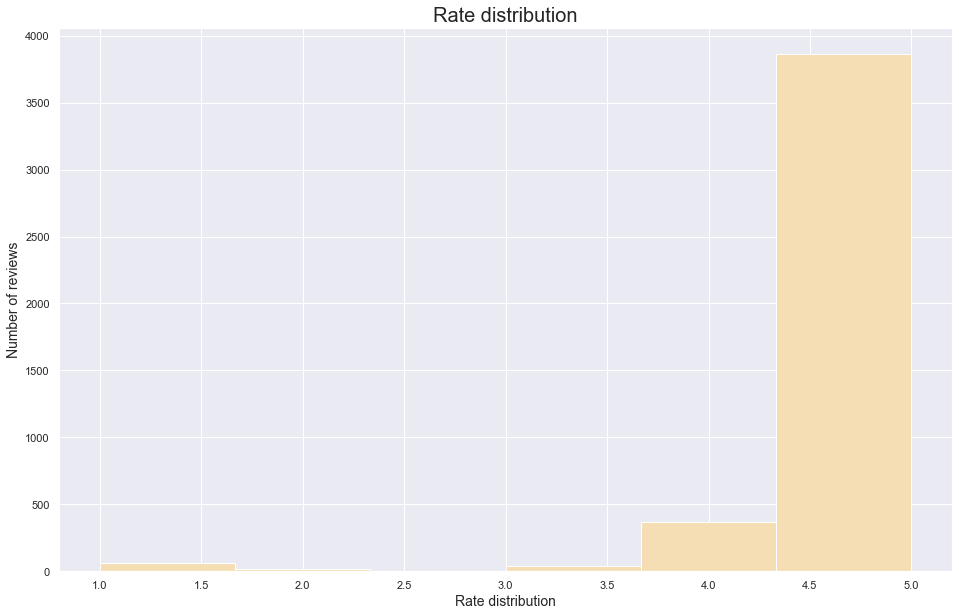

In [15]:
ax = df['Rate'].hist(color='wheat', bins=6, figsize=(16, 10))
ax.set_xlabel('Rate distribution', fontsize=14)
ax.set_ylabel('Number of reviews', fontsize=14)
ax.set_title('Rate distribution', fontsize=20)

plt.savefig('imgs/Rate_dist.png');

In [21]:
df.groupby('Brand')['Rate'].mean().sort_values(ascending=False)

Brand
nokia      5.000000
vivo       5.000000
google     4.888889
apple      4.854404
oneplus    4.823529
samsung    4.813550
oppo       4.800000
xiaomi     4.746269
huawei     4.729084
Name: Rate, dtype: float64

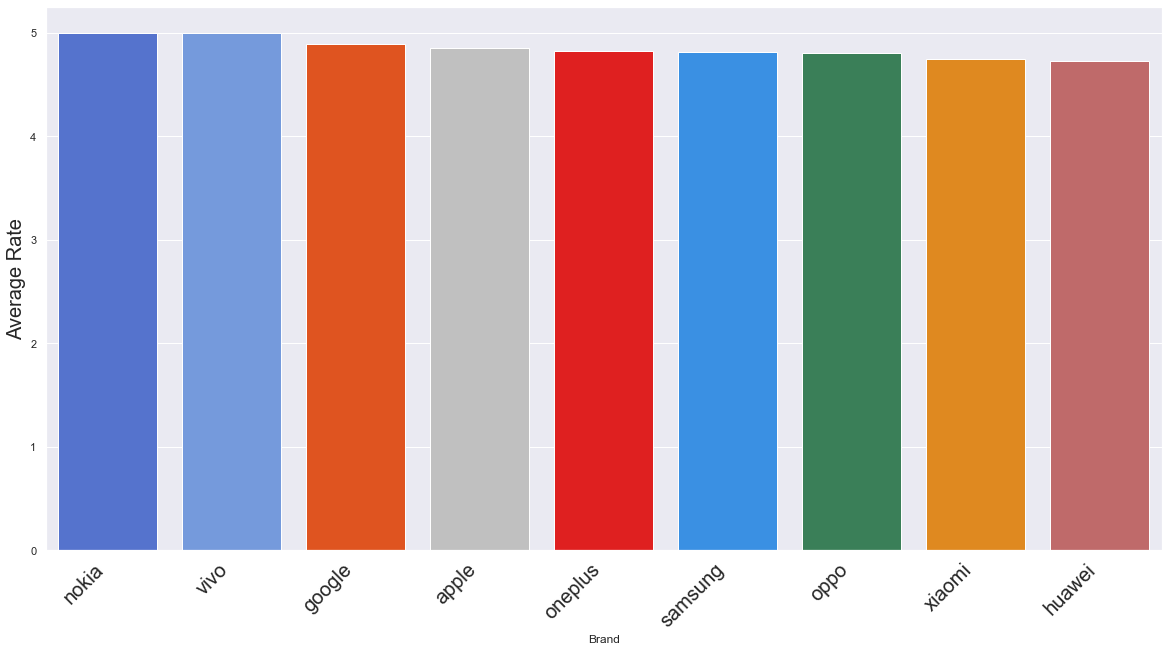

In [23]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=df.groupby('Brand')['Rate'].mean().sort_values(ascending=False).index, 
                 y=df.groupby('Brand')['Rate'].mean().sort_values(ascending=False).values, 
                 palette=color_dic)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontdict={'fontsize': 20})
ax.set_ylabel('Average Rate', fontsize=20);
plt.savefig('imgs/Rate_dist_brands.png')

### As we can see before, only apple and samsung are representative enough.

## 1.4 Number of words distribution

In [27]:
df['Number of words'] = df['Review'].apply(lambda x: len(x.split()))

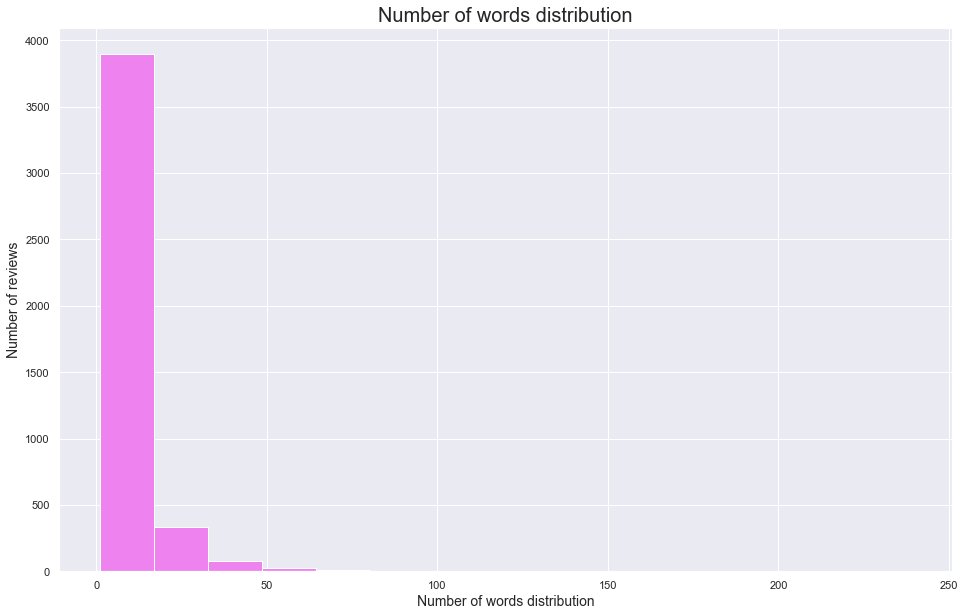

In [32]:
ax = df['Number of words'].hist(color='violet', bins=15, figsize=(16, 10))
ax.set_xlabel('Number of words distribution', fontsize=14)
ax.set_ylabel('Number of reviews', fontsize=14)
ax.set_title('Number of words distribution', fontsize=20)

plt.savefig('imgs/NoW_dist.png');

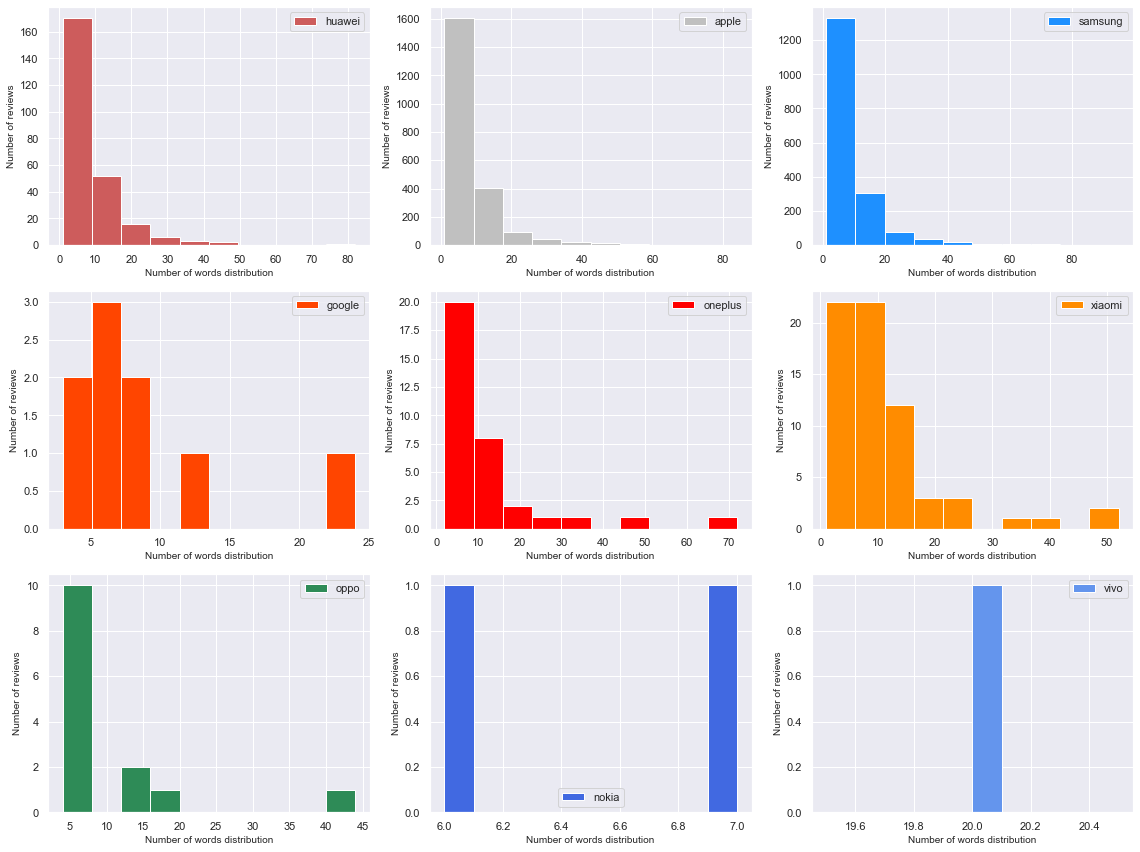

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

for n, i in enumerate(list_of_brands):
    r, c = n//3, n%3
    brand_now = df[df['Brand'] == i]['Number of words']
    cax = brand_now[brand_now<100].hist(ax=axes[r, c], color=color_dic[i], label=i)
    cax.set_xlabel('Number of words distribution', fontsize=10)
    cax.set_ylabel('Number of reviews', fontsize=10);
    cax.legend()

fig.tight_layout()

plt.savefig('imgs/Now_dist_brand.png');

We can see that all brands with sufficient number of reviews converges to similar distribution. It resembles Poisson distribution with lambda=5.

# 2. Statistical analysis

As we say before, it is better to consider only samsung and apple reviews.

In [44]:
df = df[(df['Brand'] == 'apple') | (df['Brand'] == 'samsung')].reset_index(drop=True)

## 2.1 User satisfaction

Let's research whether the users of Samsung and the users of Apple are equally satisfied with their smartphones or no. For this task we should compare mean values of their rates. For this reason, we can use Mann-Whitney's test.

$H_0\colon$ User satisfaction rate is the same for both Apple and Samsung.

$H_1\colon$ User satisfaction is different for both companies.

p-value = 0.05

In [50]:
apple_rates = df[df['Brand']=='apple']['Rate'].values
samsung_rates = df[df['Brand']=='samsung']['Rate'].values

In [56]:
stats.mannwhitneyu(apple_rates, samsung_rates, alternative='two-sided')

MannwhitneyuResult(statistic=2000602.5, pvalue=0.02136200577467146)

We can see that pvalue is less than 0.05, so we can reject our null-hypothesis amd make the conclusion that rate of satisfaction is different for both of these companies.

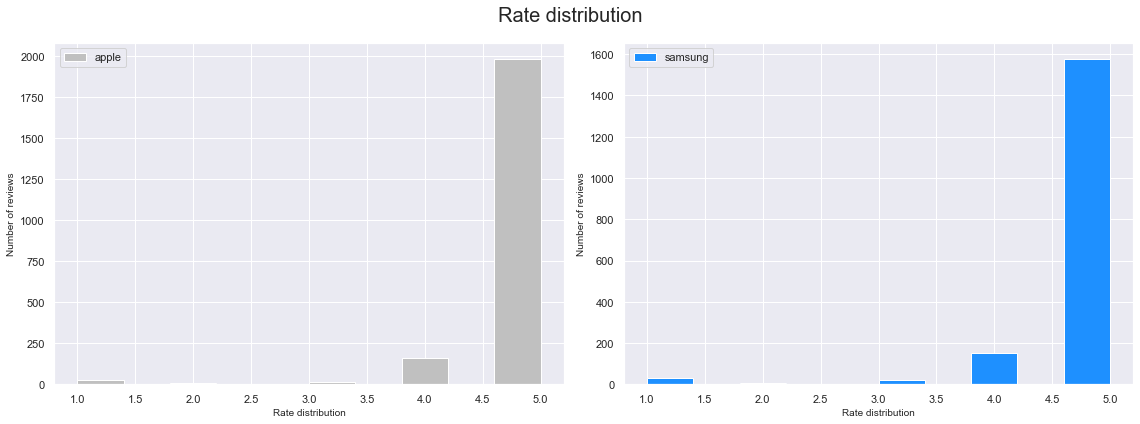

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

fig.suptitle('Rate distribution', fontsize=20)

for n, i in enumerate(['apple', 'samsung']):
    c = n%2
    brand_rate = df[df['Brand'] == i]['Rate']
    cax = brand_rate.hist(ax=axes[c], color=color_dic[i], label=i)
    cax.set_xlabel('Rate distribution', fontsize=10)
    cax.set_ylabel('Number of reviews', fontsize=10);
    cax.legend()
    

fig.tight_layout()

plt.savefig('imgs/samsung_apple.png');

We can see that distributions are slightly different.